In [28]:
pip install torch torchvision pandas tqdm pillow scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
mappeddataset = "data/image_mapping.csv";

maped = pd.read_csv(mappeddataset, low_memory=False)

print("\n--- Columns ---")
print(maped.columns[:20])  # first 20 col names




--- Columns ---
Index(['idx', 'image_filename', 'ra', 'dec',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_fraction',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_debiased',
       't01_smooth_or_features_a02_features_or_disk_flag',
       't01_smooth_or_features_a03_star_or_artifact_count',
       't01_smooth_or_features_a03_star_or_artifact_weight',
       't01_smooth_or_features_a03_star_or_artifact_fraction',
       't01_smooth_or_features_a03_star_or_artifact_weight

In [30]:
# -----------------------------
# 1️⃣ Imports
# -----------------------------
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [31]:
# -----------------------------
# 2️⃣ Load dataset
# -----------------------------
mapping_df = pd.read_csv("data/image_mapping.csv")
print("Dataset loaded:", mapping_df.shape)

Dataset loaded: (999, 172)


In [32]:
# -----------------------------
# 3️⃣ Assign Labels
# -----------------------------
# Binary labels: 0 = Smooth, 1 = Features/Disk
def assign_binary_label(row):
    if row['t01_smooth_or_features_a01_smooth_fraction'] > row['t01_smooth_or_features_a02_features_or_disk_fraction']:
        return 0
    else:
        return 1

mapping_df['binary_label'] = mapping_df.apply(assign_binary_label, axis=1)

In [33]:
# Multi-class labels: 0 = Smooth, 1 = Features/Disk, 2 = Star/Artifact
def assign_multiclass_label(row):
    fractions = {
        0: row['t01_smooth_or_features_a01_smooth_fraction'],
        1: row['t01_smooth_or_features_a02_features_or_disk_fraction'],
        2: row['t01_smooth_or_features_a03_star_or_artifact_fraction']
    }
    return max(fractions, key=fractions.get)

mapping_df['multiclass_label'] = mapping_df.apply(assign_multiclass_label, axis=1)

In [34]:
print("Binary label distribution:")
print(mapping_df['binary_label'].value_counts())
print("\nMulti-class label distribution:")
print(mapping_df['multiclass_label'].value_counts())

Binary label distribution:
binary_label
0    522
1    477
Name: count, dtype: int64

Multi-class label distribution:
multiclass_label
0    527
1    470
2      2
Name: count, dtype: int64


In [35]:
# -----------------------------
# 4️⃣ PyTorch Dataset
# -----------------------------
class GalaxyDataset(Dataset):
    def __init__(self, df, label_type='binary', transform=None):
        self.df = df
        self.label_type = label_type
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_filename']
        label = self.df.iloc[idx][f'{self.label_type}_label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [36]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [37]:
# Example: binary dataset
binary_dataset = GalaxyDataset(mapping_df, label_type='binary', transform=transform)

# Example: multi-class dataset
multiclass_dataset = GalaxyDataset(mapping_df, label_type='multiclass', transform=transform)

In [38]:
# -----------------------------
# 5️⃣ Train/Test split
# -----------------------------
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

binary_train, binary_test = split_dataset(binary_dataset)
multi_train, multi_test = split_dataset(multiclass_dataset)

binary_train_loader = DataLoader(binary_train, batch_size=32, shuffle=True)
binary_test_loader = DataLoader(binary_test, batch_size=32, shuffle=False)

multi_train_loader = DataLoader(multi_train, batch_size=32, shuffle=True)
multi_test_loader = DataLoader(multi_test, batch_size=32, shuffle=False)

In [39]:
# # -----------------------------
# # 6️⃣ CNN Model
# # -----------------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)

        # Dummy input to compute flattened size
        self._to_linear = None
        self.convs(torch.zeros(1, 3, 128, 128))  # pass dummy input
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        if self._to_linear is None:
            self._to_linear = x.view(1, -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [40]:
# -----------------------------
# 7️⃣ Training Function
# -----------------------------
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

In [41]:
# -----------------------------
# 8️⃣ Evaluation Function
# -----------------------------
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

# Training

In [42]:
# -----------------------------
# 9️⃣ Train & Evaluate Binary Classification
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
binary_model = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

train_model(binary_model, binary_train_loader, criterion, optimizer, device, epochs=10)
binary_acc = evaluate_model(binary_model, binary_test_loader, device)
print(f"Binary Classification Test Accuracy: {binary_acc:.2f}%")

Epoch 1/10: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch [1/10] Loss: 1.9267


Epoch 2/10: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Epoch [2/10] Loss: 0.5744


Epoch 3/10: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch [3/10] Loss: 0.4903


Epoch 4/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [4/10] Loss: 0.3922


Epoch 5/10: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


Epoch [5/10] Loss: 0.3278


Epoch 6/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [6/10] Loss: 0.3147


Epoch 7/10: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Epoch [7/10] Loss: 0.2822


Epoch 8/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [8/10] Loss: 0.2796


Epoch 9/10: 100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


Epoch [9/10] Loss: 0.2794


Epoch 10/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [10/10] Loss: 0.2799
Binary Classification Test Accuracy: 83.00%


In [43]:
# -----------------------------
# 🔟 Train & Evaluate Multi-Class Classification
# -----------------------------
multi_model = SimpleCNN(num_classes=3)
criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(multi_model.parameters(), lr=0.001)

train_model(multi_model, multi_train_loader, criterion_multi, optimizer_multi, device, epochs=10)
multi_acc = evaluate_model(multi_model, multi_test_loader, device)
print(f"Multi-Class Classification Test Accuracy: {multi_acc:.2f}%")

Epoch 1/10: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch [1/10] Loss: 1.2661


Epoch 2/10: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]


Epoch [2/10] Loss: 0.4769


Epoch 3/10: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Epoch [3/10] Loss: 0.3656


Epoch 4/10: 100%|██████████| 25/25 [00:30<00:00,  1.20s/it]


Epoch [4/10] Loss: 0.3601


Epoch 5/10: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Epoch [5/10] Loss: 0.3418


Epoch 6/10: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch [6/10] Loss: 0.3154


Epoch 7/10: 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


Epoch [7/10] Loss: 0.2918


Epoch 8/10: 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


Epoch [8/10] Loss: 0.2742


Epoch 9/10: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


Epoch [9/10] Loss: 0.2870


Epoch 10/10: 100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Epoch [10/10] Loss: 0.3309
Multi-Class Classification Test Accuracy: 88.50%


# Evaluation

In [44]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader, device, class_names=None, num_images_to_show=5):
    model.eval()
    y_true = []
    y_pred = []
    images_list = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            images_list.extend(images.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Automatically handle class names
    if class_names is None:
        unique_classes = np.unique(np.concatenate([y_true, y_pred]))
        class_names = [str(c) for c in unique_classes]
    
    # Print metrics
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=range(len(class_names)), target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Show some sample predictions
    print(f"\nShowing {num_images_to_show} sample predictions:")
    for i in range(min(num_images_to_show, len(images_list))):
        img_tensor = images_list[i]
        img = img_tensor.permute(1,2,0).numpy()  # CHW → HWC
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        plt.title(f"True: {true_label}, Predicted: {pred_label}")
        plt.axis('off')
        plt.show()


Test Accuracy: 83.00%

Classification Report:
               precision    recall  f1-score   support

       Smooth       0.80      0.91      0.85       108
Features/Disk       0.87      0.74      0.80        92

     accuracy                           0.83       200
    macro avg       0.84      0.82      0.83       200
 weighted avg       0.83      0.83      0.83       200



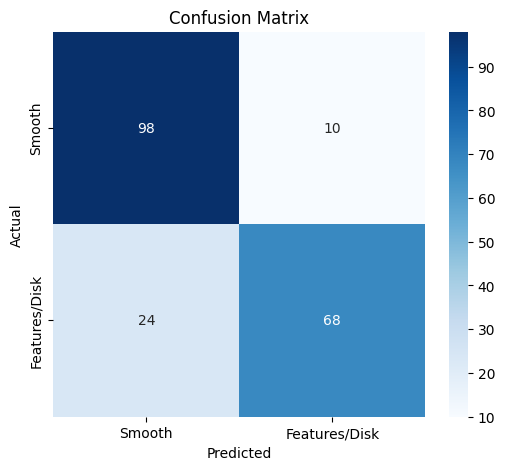


Showing 5 sample predictions:


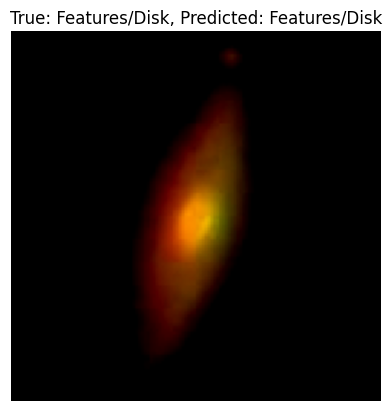

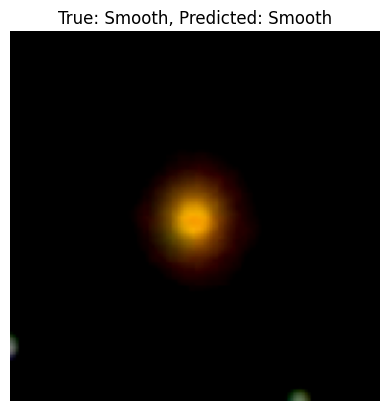

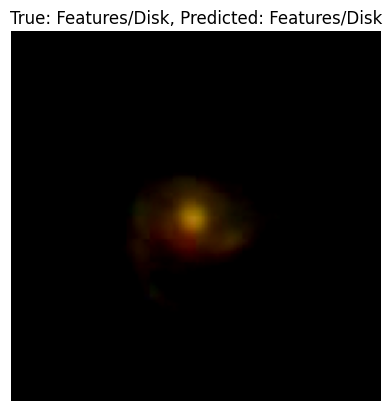

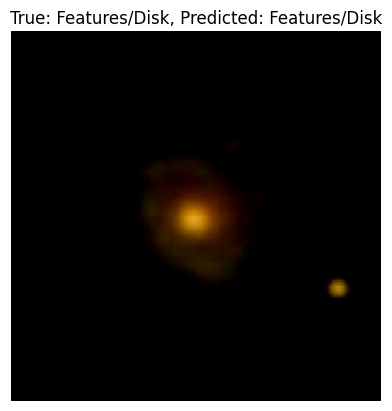

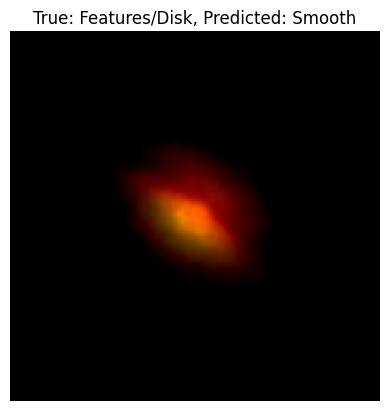

In [45]:
binary_class_names = ["Smooth", "Features/Disk"]
evaluate_model(binary_model, binary_test_loader, device, class_names=binary_class_names, num_images_to_show=5)


Test Accuracy: 88.50%

Classification Report:
               precision    recall  f1-score   support

       Smooth       0.82      0.99      0.90       100
Features/Disk       0.97      0.79      0.87        99
     Artifact       0.00      0.00      0.00         1

     accuracy                           0.89       200
    macro avg       0.60      0.59      0.59       200
 weighted avg       0.90      0.89      0.88       200



c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

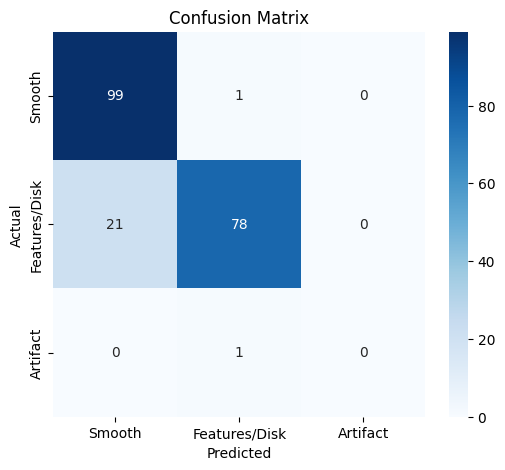


Showing 5 sample predictions:


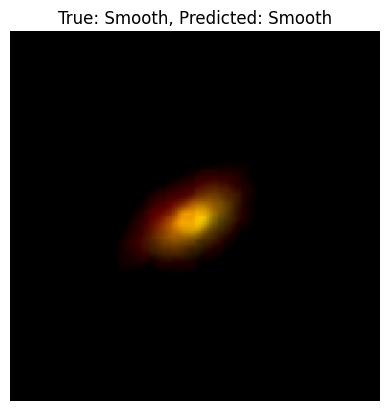

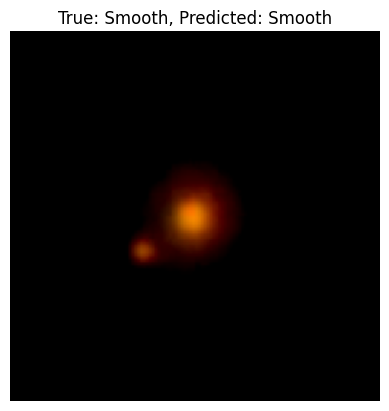

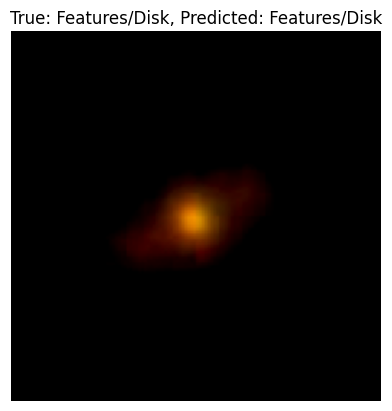

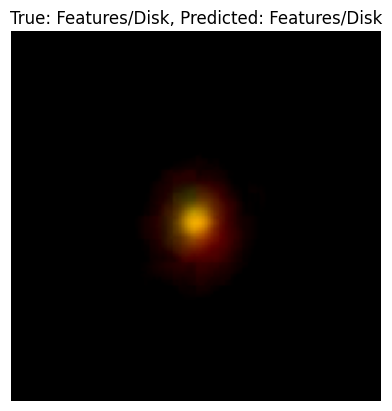

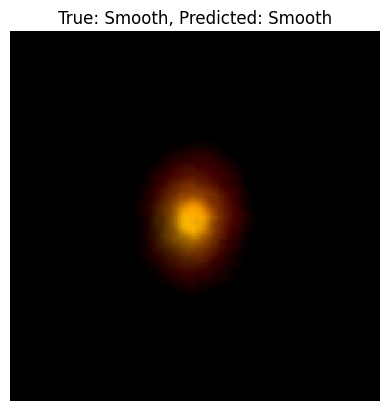

In [46]:
multi_class_names = ["Smooth", "Features/Disk", "Artifact"]  # adjust to actual classes in your dataset
evaluate_model(multi_model, multi_test_loader, device, class_names=multi_class_names, num_images_to_show=5)
